In [1]:
# All required imports
# import tensorflow as tf
# print("GPU available", tf.test.is_gpu_available())
from joblib import Parallel, delayed
from tqdm import tqdm
import numba
from typing import Tuple, List
from matchms import Spectrum
from matchms.typing import SpectrumType
import numpy as np
import pandas as pd
from pathlib import Path
import json

from matchms import Spectrum

from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def process_spectrum(spectrum):
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum


def get_ref_spectra_from_df(spectra_df):
    # This function will take a dataframe with spectra and return a list of matchms spectra
    # Argh, This function is annoyingly slow. Added simple parallelization.
    
    # for index, row in spectra_df.iterrows():
    def fn(index, row):
        pbid = row["pbid"]
        precursor_mz = row["precursor_mz"]
        smiles = row["pb_smiles"]
        inchikey = row["pb_inchikey"]
        mz_array = np.array(json.loads(row["peaks_mz"]))
        intensity_array = np.array(json.loads(row["peaks_intensities"]))
        sp = Spectrum(mz=mz_array, intensities=intensity_array,
                        metadata={'id': pbid, 
                                'precursor_mz': precursor_mz, 
                                'smiles': smiles, 
                                'inchikey': inchikey}) 
        sp = process_spectrum(sp)
        return sp
    
    spectra = Parallel(-2)(delayed(fn)(index, row) for index, row in tqdm(spectra_df.iterrows(), total=len(spectra_df)))
    spectra = [s for s in spectra if s is not None]
    return spectra


In [2]:
ref_spectra_df_path = Path("example_dataset_tornike.csv")
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
large_references = get_ref_spectra_from_df(ref_spectra_df)

100%|██████████| 100001/100001 [00:28<00:00, 3479.77it/s]


In [4]:
queries = large_references[:100]
references = large_references[100:400]

In [31]:
import time

def collect_peak_pairs(spec1: np.ndarray, spec2: np.ndarray,
                       tolerance: float, shift: float = 0, mz_power: float = 0.0,
                       intensity_power: float = 1.0):
    # pylint: disable=too-many-arguments
    """Find matching pairs between two spectra.

    Args
    ----
    spec1:
        Spectrum peaks and intensities as numpy array.
    spec2:
        Spectrum peaks and intensities as numpy array.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift spectra peaks by shift. The default is 0.
    mz_power:
        The power to raise mz to in the cosine function. The default is 0, in which
        case the peak intensity products will not depend on the m/z ratios.
    intensity_power:
        The power to raise intensity to in the cosine function. The default is 1.

    Returns
    -------
    matching_pairs : numpy array
        Array of found matching peaks.
    """
    matches = find_matches(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global a
    # a = matches
    # matches_op = find_matches_opt(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global b
    # b = matches_op
    # assert np.allclose(matches, matches_op)
    
    idx1 = [x[0] for x in matches]
    idx2 = [x[1] for x in matches]
    if len(idx1) == 0:
        return None
    matching_pairs = []
    for i, idx in enumerate(idx1):
        power_prod_spec1 = (spec1[idx, 0] ** mz_power) * (spec1[idx, 1] ** intensity_power)
        power_prod_spec2 = (spec2[idx2[i], 0] ** mz_power) * (spec2[idx2[i], 1] ** intensity_power)
        # print((idx, idx2[i], power_prod_spec1,power_prod_spec2))
        # raise
        matching_pairs.append([idx, idx2[i], power_prod_spec1 * power_prod_spec2])
    # print(matching_pairs)
    # raise
    return np.array(matching_pairs.copy())


# @numba.njit
def find_matches(spec1_mz: np.ndarray, spec2_mz: np.ndarray,
                 tolerance: float, shift: float = 0) -> List[Tuple[int, int]]:
    """Faster search for matching peaks.
    Makes use of the fact that spec1 and spec2 contain ordered peak m/z (from
    low to high m/z).

    Parameters
    ----------
    spec1_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    spec2_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift peaks of second spectra by shift. The default is 0.

    Returns
    -------
    matches
        List containing entries of type (idx1, idx2).

    """
    
    lowest_idx = 0
    matches = []
    for peak1_idx in range(spec1_mz.shape[0]):
        mz = spec1_mz[peak1_idx]
        low_bound = mz - tolerance
        high_bound = mz + tolerance
        for peak2_idx in range(lowest_idx, spec2_mz.shape[0]):
            mz2 = spec2_mz[peak2_idx] + shift
            if mz2 > high_bound:
                break
            if mz2 < low_bound:
                lowest_idx = peak2_idx
            else:
                matches.append((peak1_idx, peak2_idx))
    # print(matches)
    return matches


@numba.njit(fastmath=True)
def score_best_matches(matching_pairs: np.ndarray, spec1: np.ndarray,
                       spec2: np.ndarray, mz_power: float = 0.0,
                       intensity_power: float = 1.0) -> Tuple[float, int]:
    """Calculate cosine-like score by multiplying matches. Does require a sorted
    list of matching peaks (sorted by intensity product)."""
    score = float(0.0)
    used_matches = int(0)
    used1 = set()
    used2 = set()
    for i in range(matching_pairs.shape[0]):
        if not matching_pairs[i, 0] in used1 and not matching_pairs[i, 1] in used2:
            score += matching_pairs[i, 2]
            used1.add(matching_pairs[i, 0])  # Every peak can only be paired once
            used2.add(matching_pairs[i, 1])  # Every peak can only be paired once
            used_matches += 1
    # print(score)
    # raise
    # Normalize score:
    spec1_power = spec1[:, 0] ** mz_power * spec1[:, 1] ** intensity_power
    spec2_power = spec2[:, 0] ** mz_power * spec2[:, 1] ** intensity_power
    # print(spec1_power)
    # print(spec2_power)
    # raise
    score_norm = (np.sum(spec1_power ** 2) ** 0.5 * np.sum(spec2_power ** 2) ** 0.5)
    score = score/score_norm
    # print(score, "/", score_norm)
    # raise
    return score, used_matches

start_collect_peaks = time.time()
pairs_to_score_list = []

for spectrum_1 in tqdm(references):
    for spectrum_2 in queries:
        spec1 = spectrum_1.peaks.to_numpy
        spec2 = spectrum_2.peaks.to_numpy
        
        matching_pairs = collect_peak_pairs(
                    spectrum_1.peaks.to_numpy, 
                    spectrum_2.peaks.to_numpy, 
                    tolerance=0.1,
                    shift=0.0, 
                    mz_power=0.0,
                    intensity_power=1.0
        ) 
        if matching_pairs is not None:
            pairs_to_score_list.append([ matching_pairs, spectrum_1, spectrum_2])  
scores = []
for matching_pairs, spectrum_1, spectrum_2 in tqdm(pairs_to_score_list):
    scores.append(score_best_matches(matching_pairs, spectrum_1.peaks.to_numpy, spectrum_2.peaks.to_numpy,
                                0.0, 1.0))
end_collect_peaks = time.time()
print("Time to collect matching pairs: ", end_collect_peaks - start_collect_peaks)

  0%|          | 0/22970 [00:00<?, ?it/s]

0.012345400054709363


RuntimeError: No active exception to reraise

In [61]:
def spectra_peaks_to_tensor(spectra: list, fill: float):
    sp_max_shape = max(len(s.peaks) for s in spectra)
    sp = np.full((len(spectra), sp_max_shape, 2), fill, 'float64')
    batch = np.zeros(len(spectra),dtype=np.uint64)
    for i, s in enumerate(spectra):
        sp[i, :len(s.peaks)] = s.peaks.to_numpy
        batch[i] = len(s.peaks)
    return sp, batch

references_batch, references_batch_size \
    = spectra_peaks_to_tensor(references, fill=-1e6)
queries_batch, queries_batch_size \
    = spectra_peaks_to_tensor(queries, fill=-1e6)

In [62]:
np.save('builddir/references_mz.npy', references_batch[...,0])
np.save('builddir/references_int.npy', references_batch[...,1])
np.save('builddir/references_batch_size.npy', references_batch_size)
np.save('builddir/queries_mz.npy', queries_batch[...,0])
np.save('builddir/queries_int.npy', queries_batch[...,1])
np.save('builddir/queries_batch_size.npy', queries_batch_size)
# np.save('builddir/scores_100x100.npy', np.array(scores))

In [52]:
load_scores_true = np.load('builddir/scores_100x100.npy')
print(load_scores_true)
print(load_scores_true.shape, load_scores_true.dtype)
print(np.sort(load_scores_true[:,0]))

[[8.63016898e-03 5.00000000e+00]
 [1.57968525e-02 6.00000000e+00]
 [4.26263552e-02 7.00000000e+00]
 ...
 [6.88239339e-03 6.00000000e+00]
 [1.81943264e-02 9.00000000e+00]
 [4.84264270e-02 1.10000000e+01]]
(22970, 2) float64
[6.47754888e-07 7.81780158e-07 8.52989985e-07 ... 9.97076190e-01
 9.97387727e-01 9.97983564e-01]


In [63]:
load_scores = np.load('builddir/results.npy')
print(load_scores)
print(load_scores.shape, load_scores.dtype)
print(np.sort(load_scores[:,0]))

[[0.00863017 5.        ]
 [0.01579685 6.        ]
 [0.04262635 7.        ]
 ...
 [0.00768438 6.        ]
 [0.00716775 5.        ]
 [0.0072776  4.        ]]
(4002, 2) float64
[1.89974935e-06 2.08323263e-06 2.16184708e-06 ... 9.97076154e-01
 9.97387826e-01 9.97983634e-01]


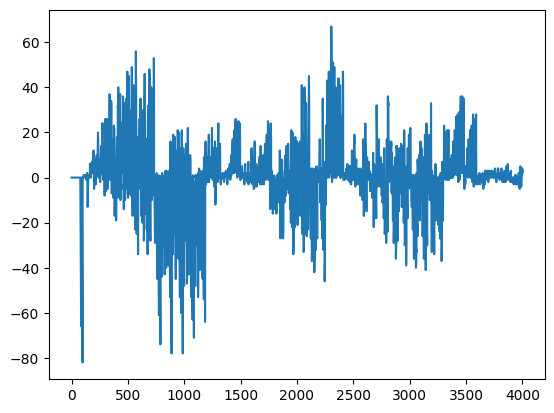

In [59]:

import matplotlib.pyplot as plt
plt.plot(load_scores[:,1] - load_scores_true[:len(load_scores[:,1]),1])